# **Experiment Notebook - Classification**



## The Brief: 
The NBA draft is an annual event in which teams select players from their American colleges as well as international professional leagues to join their rosters. Moving to the NBA league is a big deal for any basketball player. 

Sport commentators and fans are very excited to follow the careers of college players and guess who will be drafted by an NBA team.

The task is to build a model that will predict if a college basketball player will be drafted to join the NBA league based on his statistics for the current season.

The metric used to assess model performance is AUROC (Area Under ROC).

The model used for this experiment is xgboost.

Week 5 experiment: Exploration on data preprocessing

### 1. Load the dataset

In [1]:
# load modules
%load_ext autoreload
%autoreload 2

In [2]:
# pip install group package
! pip install -i https://test.pypi.org/simple/ grp_krml_group3==2024.0.2.2

Looking in indexes: https://test.pypi.org/simple/


In [3]:
# data libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# load data
df_metadata = pd.read_csv('../data/raw/metadata.csv')
df_sample_sub = pd.read_csv('../data/raw/sample_submission.csv')
df_test = pd.read_csv('../data/raw/test.csv')
df_train = pd.read_csv('../data/raw/train.csv')

In [5]:
# cleaning
df_train['set_type'] = 'train'
df_test['set_type'] = 'test'
df_test['drafted'] = np.nan

df_explore = pd.concat([df_train,df_test])

### 2. Explore the datasets

#### 2.1 Exploration

In [6]:
df_metadata.head()

,feature,name,description
0,1,team,Name of team
1,2,conf,Name of conference
2,3,GP,Games played
3,4,Min_per,Player's percentage of available team minutes ...
4,5,ORtg,ORtg - Offensive Rating (available since the 1...


In [7]:
df_sample_sub.head()

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.51
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.92
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.14
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.71
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.60


In [8]:
df_test.head()

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,oreb,dreb,treb,ast,stl,blk,pts,player_id,set_type,drafted
0,Morgan St.,MEAC,2,3.0,115.1,4.7,50.0,50.00,0.0,4.6,...,0.0000,0.3333,0.3333,0.0000,0.0000,0.0000,1.0000,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,test,NaN
1,South Carolina St.,MEAC,11,17.6,61.1,18.6,34.7,35.18,2.5,15.7,...,0.2727,1.4545,1.7273,0.4545,0.1818,0.0000,2.3636,52a518bb-b34a-4b43-adee-5e996cb853fa,test,NaN
2,Binghamton,AE,9,28.6,91.9,23.8,54.1,52.49,6.4,22.5,...,1.3333,4.4444,5.7778,1.0000,0.6667,1.8889,8.8889,ad3d9117-b6bf-4675-ab97-3497acf3e555,test,NaN
3,Illinois,B10,7,1.3,111.0,10.4,83.3,83.33,0.0,13.4,...,0.0000,0.2857,0.2857,0.0000,0.0000,0.0000,0.7143,eaf66a5c-6f4c-4070-bc70-a99d731b3740,test,NaN
4,Iowa St.,B12,23,78.5,103.1,21.5,54.0,56.12,3.6,10.2,...,1.0435,2.8696,3.9130,1.1739,0.8261,0.0870,14.3043,55d07491-5bd1-447f-844e-9cb36eaa442e,test,NaN


In [9]:
df_train.head()

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted,set_type
0,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,...,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,b2716b2d-3422-4959-9fe7-fe496414a4e8,0.0,train
1,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,...,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,bb387960-e3a0-4ffd-96ae-184bad07cb8a,0.0,train
2,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,...,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,89bbdf11-eadd-4de4-95e5-03f7e2874aa1,0.0,train
3,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,...,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,0c87ada8-8446-4ea2-a05b-bd07aed5f37a,0.0,train
4,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,...,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,84661e00-ad20-4308-817e-efa8da52a86c,0.0,train


In [10]:
print('Train set shape: ', df_train.shape)
print('Test set shape: ', df_test.shape)

Train set shape:  (46618, 65)
Test set shape:  (4970, 65)


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46618 entries, 0 to 46617
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 46618 non-null  object 
 1   conf                 46618 non-null  object 
 2   GP                   46618 non-null  int64  
 3   Min_per              46618 non-null  float64
 4   Ortg                 46618 non-null  float64
 5   usg                  46618 non-null  float64
 6   eFG                  46618 non-null  float64
 7   TS_per               46618 non-null  float64
 8   ORB_per              46618 non-null  float64
 9   DRB_per              46618 non-null  float64
 10  AST_per              46618 non-null  float64
 11  TO_per               46618 non-null  float64
 12  FTM                  46618 non-null  int64  
 13  FTA                  46618 non-null  int64  
 14  FT_per               46618 non-null  float64
 15  twoPM                46618 non-null 

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4970 entries, 0 to 4969
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 4970 non-null   object 
 1   conf                 4970 non-null   object 
 2   GP                   4970 non-null   int64  
 3   Min_per              4970 non-null   float64
 4   Ortg                 4970 non-null   float64
 5   usg                  4970 non-null   float64
 6   eFG                  4970 non-null   float64
 7   TS_per               4970 non-null   float64
 8   ORB_per              4970 non-null   float64
 9   DRB_per              4970 non-null   float64
 10  AST_per              4970 non-null   float64
 11  TO_per               4970 non-null   float64
 12  FTM                  4970 non-null   int64  
 13  FTA                  4970 non-null   int64  
 14  FT_per               4970 non-null   float64
 15  twoPM                4970 non-null   i

In [13]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51588 entries, 0 to 4969
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 51588 non-null  object 
 1   conf                 51588 non-null  object 
 2   GP                   51588 non-null  int64  
 3   Min_per              51588 non-null  float64
 4   Ortg                 51588 non-null  float64
 5   usg                  51588 non-null  float64
 6   eFG                  51588 non-null  float64
 7   TS_per               51588 non-null  float64
 8   ORB_per              51588 non-null  float64
 9   DRB_per              51588 non-null  float64
 10  AST_per              51588 non-null  float64
 11  TO_per               51588 non-null  float64
 12  FTM                  51588 non-null  int64  
 13  FTA                  51588 non-null  int64  
 14  FT_per               51588 non-null  float64
 15  twoPM                51588 non-null  int64

In [14]:
df_explore[df_explore.duplicated]

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted,set_type


#### 2.2 Preprocessing

In [15]:
# fill na values with 0
subset_na_cols = ['dporpag', 'stops', 'gbpm', 'ogbpm', 'dgbpm', 'mp', 'oreb', 'dreb'\
                 , 'treb', 'ast', 'stl', 'blk', 'pts', 'rimmade', 'midmade', 'dunksmade']

# features with ratios
ratio_cols = ['ast_tov', 'dunks_ratio', 'rim_ratio', 'mid_ratio']

# categorical columns
cat_cols = ['team', 'conf','yr']

# unique columns
uniq_cols = ['player_id', 'num']

# cols to drop
drop_cols = ['rimmade_rimmiss', 'midmade_midmiss', 'dunksmiss_dunksmade', 'year']

# dropped features from feature impact analysis
drop_feats = ['porpag', 'drtg', 'dbpm', 'obpm', 'bpm', 'type', 'treb', 'FTM', 'TP_per', 'TPM', 'ast_tov'\
              , 'eFG', 'stops', 'Ortg', 'twoPM'] 

In [16]:
# cleaning 
df_explore['Rec_Rank'] = df_explore['Rec_Rank'].fillna(df_explore['Rec_Rank'].max() + 100) # those that did not have recruiting ranks are assumed given low ranks
df_explore['pick'] = df_explore['pick'].fillna(df_explore['pick'].max() + 100)

# fill values with 0
fill_zero_cols = subset_na_cols + ratio_cols
df_explore[fill_zero_cols] = df_explore[fill_zero_cols].fillna(0) 

In [17]:
# df_explore[df_explore['set_type'] == 'train'].dropna(subset=subset_na_cols, inplace=True)
df_explore['yr'].fillna('others', inplace=True) # probably non college player; grouped to others

# assume null values with worst drtg and adrtg (inverse relationship; lower score = better)
df_explore['adrtg'].fillna(df_train['adrtg'].max() + .01, inplace=True) 

In [18]:
df_explore.drop(uniq_cols + drop_cols + drop_feats, axis=1, inplace=True)

In [19]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51588 entries, 0 to 4969
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team         51588 non-null  object 
 1   conf         51588 non-null  object 
 2   GP           51588 non-null  int64  
 3   Min_per      51588 non-null  float64
 4   usg          51588 non-null  float64
 5   TS_per       51588 non-null  float64
 6   ORB_per      51588 non-null  float64
 7   DRB_per      51588 non-null  float64
 8   AST_per      51588 non-null  float64
 9   TO_per       51588 non-null  float64
 10  FTA          51588 non-null  int64  
 11  FT_per       51588 non-null  float64
 12  twoPA        51588 non-null  int64  
 13  twoP_per     51588 non-null  float64
 14  TPA          51588 non-null  int64  
 15  blk_per      51588 non-null  float64
 16  stl_per      51588 non-null  float64
 17  ftr          51588 non-null  float64
 18  yr           51588 non-null  object 
 19  ht        

### 3. Explore Target variable

In [20]:
target = 'drafted'

In [21]:
df_explore[target].value_counts()

drafted
0.0    46174
1.0      444
Name: count, dtype: int64

In [22]:
df_explore[target].value_counts(normalize=True)

drafted
0.0    0.990476
1.0    0.009524
Name: proportion, dtype: float64

<Axes: xlabel='drafted', ylabel='count'>

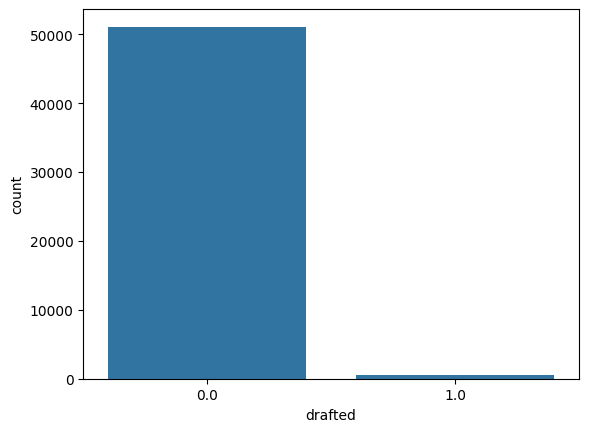

In [23]:
sns.countplot(x=target, data=df_explore, order=df_explore[target].value_counts(ascending=False).index)

### 4. Explore Features

#### Cleaning 'ht' (height) feature

In [24]:
df_explore['ht'].head()

0    2-Jun
1    4-Jun
2    4-Jun
3    4-Jun
4    8-Jun
Name: ht, dtype: object

In [25]:
# cleaning ht (height) feature
df_explore['ht'].str.extract('([a-zA-Z]+)', expand=False).value_counts() # check which months

ht
Jun    46691
May     3599
Jul      935
Apr       21
Jr         2
So         1
Fr         1
Name: count, dtype: int64

In [26]:
df_explore.columns

Index(['team', 'conf', 'GP', 'Min_per', 'usg', 'TS_per', 'ORB_per', 'DRB_per',
       'AST_per', 'TO_per', 'FTA', 'FT_per', 'twoPA', 'twoP_per', 'TPA',
       'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'adjoe', 'pfr', 'Rec_Rank',
       'rimmade', 'midmade', 'rim_ratio', 'mid_ratio', 'dunksmade',
       'dunks_ratio', 'pick', 'adrtg', 'dporpag', 'stops', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'pts', 'drafted',
       'set_type'],
      dtype='object')

In [27]:
# function to convert month to 
def get_ht_ft(x):
    x = str(x)
    if 'May' in x:
        return 5
    elif 'Jun' in x:
        return 6
    elif 'Jul' in x:
        return 7
    else:
        return 5 # if na

df_explore['ht_inches'] = df_explore['ht'].apply(get_ht_ft) * 12 + df_explore['ht'].str.extract('(\d+)', expand=False).fillna(0).astype('int')

In [28]:
df_explore.drop('ht', axis=1, inplace=True)

In [29]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51588 entries, 0 to 4969
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team         51588 non-null  object 
 1   conf         51588 non-null  object 
 2   GP           51588 non-null  int64  
 3   Min_per      51588 non-null  float64
 4   usg          51588 non-null  float64
 5   TS_per       51588 non-null  float64
 6   ORB_per      51588 non-null  float64
 7   DRB_per      51588 non-null  float64
 8   AST_per      51588 non-null  float64
 9   TO_per       51588 non-null  float64
 10  FTA          51588 non-null  int64  
 11  FT_per       51588 non-null  float64
 12  twoPA        51588 non-null  int64  
 13  twoP_per     51588 non-null  float64
 14  TPA          51588 non-null  int64  
 15  blk_per      51588 non-null  float64
 16  stl_per      51588 non-null  float64
 17  ftr          51588 non-null  float64
 18  yr           51588 non-null  object 
 19  adjoe     

#### Categorical Features v Target

In [30]:
def plot_categ_feats(feat, df, target, th):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax = ax.flatten()
    
    df_counts = df.groupby([feat, target]).size().reset_index(name='counts')
    df_pivot = df_counts.pivot_table(index=feat ,columns=target, aggfunc='sum', fill_value=0, margins=True)
    df_pcnt = df_pivot.div(df_pivot.iloc[:,-1], axis=0)
    
    value_filter = df_pcnt[('counts',1)] >= th
    df_pcnt_filtered = df_pcnt[value_filter].loc[:,('counts',1)].sort_values(ascending=False)
    sns.barplot(x=df_pcnt_filtered.index,y=df_pcnt_filtered.values, color='orange',ax=ax[0])
    
    df_cnts_filtered = df[feat].value_counts(ascending=False).filter(items = df_pcnt[value_filter].index).reindex(df_pcnt_filtered.index)
    sns.barplot(x=df_cnts_filtered.index,y=df_cnts_filtered.values, color='gray', ax=ax[1])
    
    ax[0].tick_params(axis='x', labelrotation=50)
    ax[1].tick_params(axis='x', labelrotation=50)
    
    ax[0].set_title('Pcnt of drafted per ' + feat)
    ax[1].set_title('Number of players per ' + feat)
    plt.show()

    return df_cnts_filtered

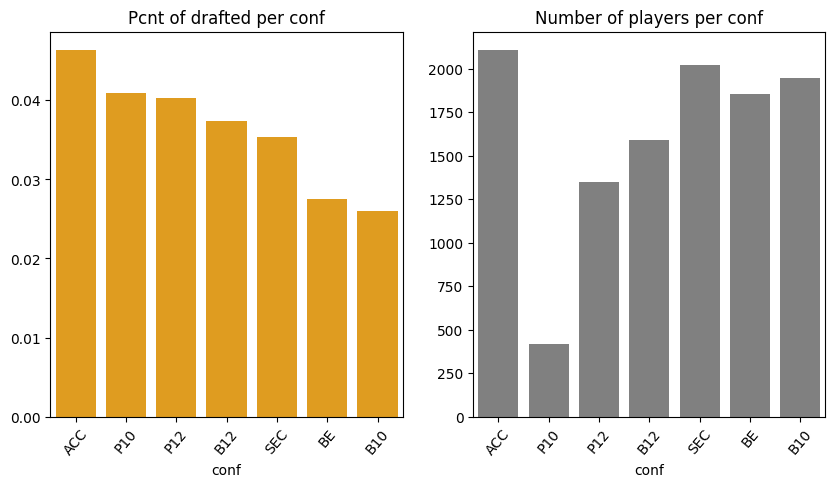

In [31]:
## [Feature Exploration]
## Exploring feature conference and its relation to the target
top_conf = plot_categ_feats('conf', df_explore, target, 0.02)

In [32]:
# creating only two values (top or others) for conf feat
df_explore['conf'] = df_explore['conf'].apply(lambda x: 'top' if x in top_conf.index else 'others')

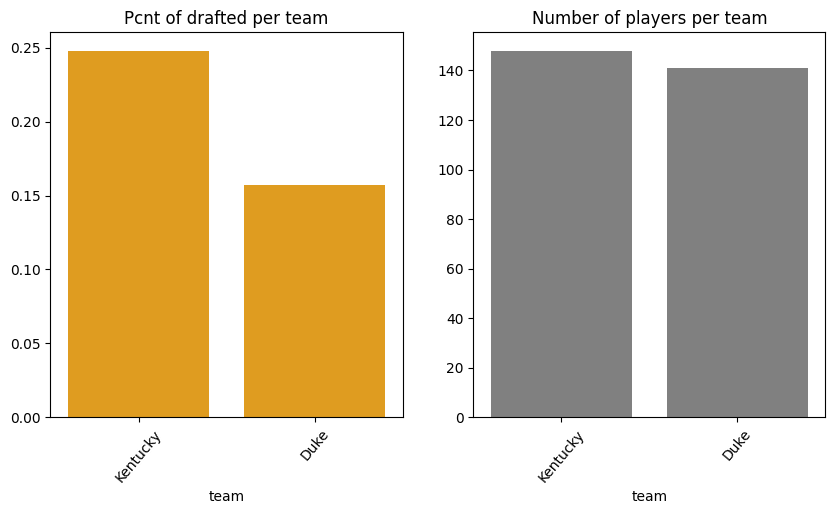

In [33]:
## [Feature Exploration]
## Exploring feature team and its relation to the target
top_team = plot_categ_feats('team', df_explore, target, 0.1)

In [34]:
# creating only two values (top or others) for conf feat
df_explore['team'] = df_explore['team'].apply(lambda x: 'top' if x in top_team.index else 'others')

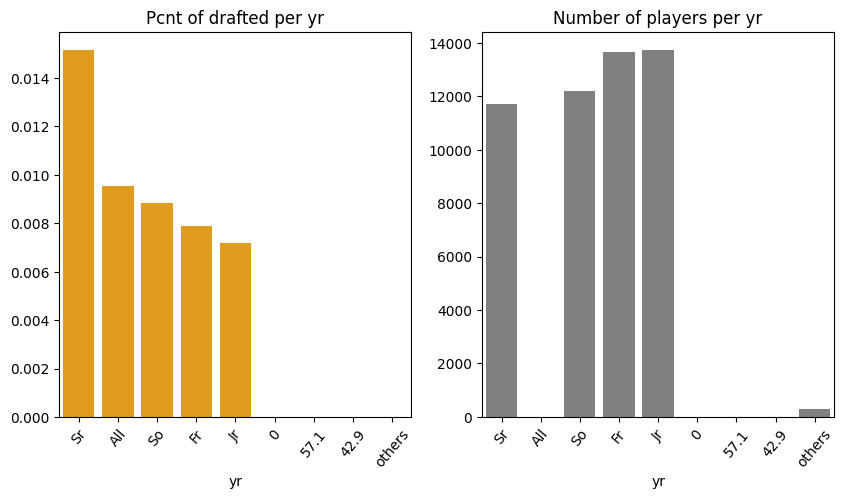

In [35]:
_ = plot_categ_feats('yr', df_explore, target, 0)

In [36]:
yr_values = ['Sr']

df_explore['yr'] = df_explore['yr'].apply(lambda x: x if x in yr_values else 'others')

#### Numerical Features v Target

In [37]:
num_cols = [x for x in df_explore.columns if x not in cat_cols + [target, 'set_type']]

In [38]:
len(num_cols)

40

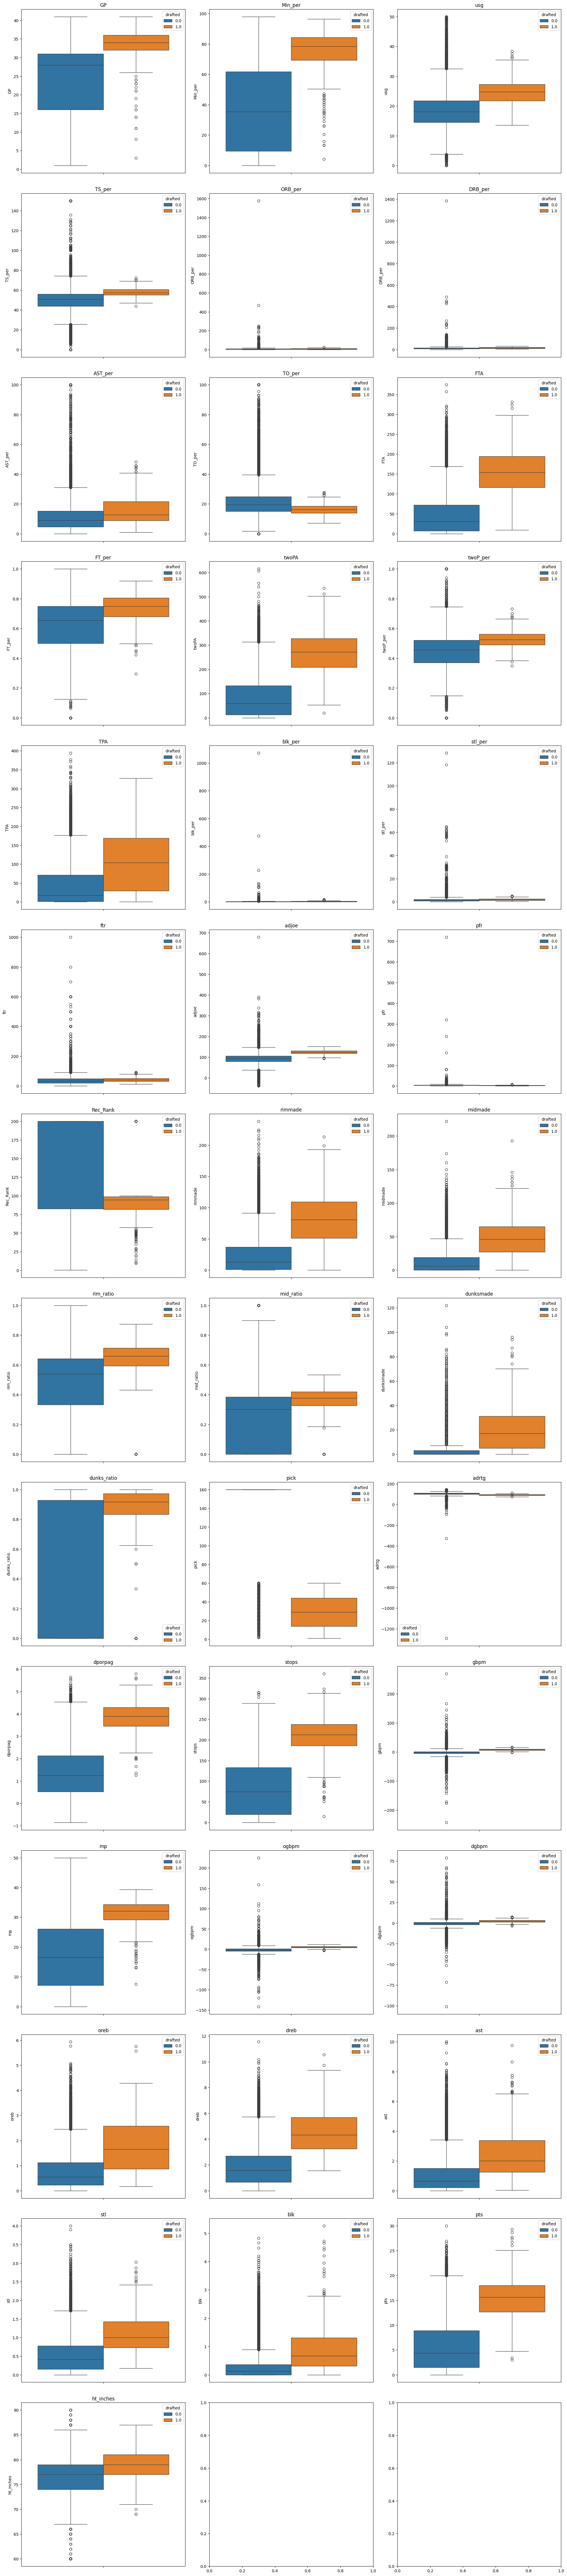

In [39]:
fig, ax = plt.subplots(int(len(num_cols)/3)+1, 3, figsize=(20,90))
ax = ax.flatten()
plt.tight_layout(pad=3)

for idx,col in enumerate(num_cols):
    sns.boxplot(y=col, hue=target, data=df_explore[df_explore['set_type'] == 'train'], ax=ax[idx])
    ax[idx].set_title(col)

plt.show()

### 5. Data Preparation

In [40]:
# create dummy variables and concat
dummies_df = []
for var in cat_cols:
    dummies_df.append(pd.get_dummies(df_explore[var], drop_first=True, prefix=var, dtype=float))

df = pd.concat([df_explore, pd.concat(dummies_df, axis=1)], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

In [41]:
df.head()

,GP,Min_per,usg,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTA,FT_per,...,ast,stl,blk,pts,drafted,set_type,ht_inches,team_top,conf_top,yr_others
0,26,29.5,16.6,44.43,1.6,4.6,15.8,16.3,14,0.714,...,1.1923,0.3462,0.0385,3.8846,0.0,train,74,0.0,0.0,1.0
1,34,60.9,14.9,54.48,3.8,6.3,13.6,19.8,45,0.667,...,1.8235,0.4118,0.2353,5.9412,0.0,train,76,0.0,0.0,1.0
2,27,72.0,21.8,47.98,2.1,8.0,14.7,15.9,67,0.672,...,1.9630,0.4815,0.0000,12.1852,0.0,train,76,0.0,1.0,0.0
3,30,44.5,16.0,53.69,4.1,9.4,13.7,23.8,27,0.519,...,1.1000,0.5667,0.1333,4.9333,0.0,train,76,0.0,0.0,0.0
4,33,56.2,22.0,54.31,8.3,18.6,8.2,22.7,114,0.561,...,0.8485,0.4545,0.3333,7.5758,0.0,train,80,0.0,0.0,0.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51588 entries, 0 to 4969
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GP           51588 non-null  int64  
 1   Min_per      51588 non-null  float64
 2   usg          51588 non-null  float64
 3   TS_per       51588 non-null  float64
 4   ORB_per      51588 non-null  float64
 5   DRB_per      51588 non-null  float64
 6   AST_per      51588 non-null  float64
 7   TO_per       51588 non-null  float64
 8   FTA          51588 non-null  int64  
 9   FT_per       51588 non-null  float64
 10  twoPA        51588 non-null  int64  
 11  twoP_per     51588 non-null  float64
 12  TPA          51588 non-null  int64  
 13  blk_per      51588 non-null  float64
 14  stl_per      51588 non-null  float64
 15  ftr          51588 non-null  float64
 16  adjoe        51588 non-null  float64
 17  pfr          51588 non-null  float64
 18  Rec_Rank     51588 non-null  float64
 19  rimmade   

### 6. Splitting Dataset

In [43]:
from sklearn.model_selection import train_test_split

X_train = df[df['set_type'] == 'train'].drop([target, 'set_type'], axis=1)
y_train = df[df['set_type'] == 'train'][target].copy()

In [44]:
# save sets into the data/processed folder
from grp_krml_group3.data.sets import save_sets

In [45]:
save_sets(X_train, y_train, None, None, None, None, path='../data/processed/save_sets')

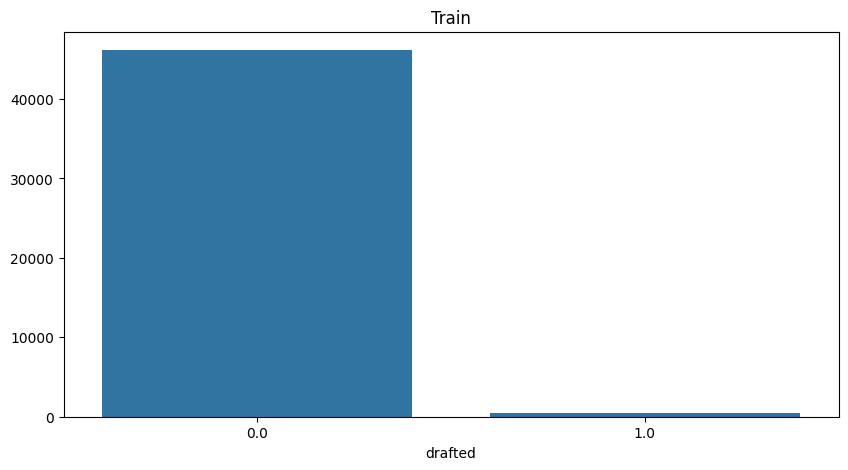

In [46]:
# checking distributions of the resulting train, and test sets
fig, ax = plt.subplots(figsize=(10,5))

y_train_cnts = y_train.value_counts()

sns.barplot(x=y_train_cnts.index,y=y_train_cnts.values, ax=ax)

ax.set_title('Train')

plt.show()

### 7. Baseline Model

In [47]:
from grp_krml_group3.models.null import NullClassifier

In [48]:
base_model = NullClassifier()

In [49]:
# creating baseline predictions with the same shape as the train set
train_baseline_preds = base_model.fit_predict(y_train)

In [50]:
from grp_krml_group3.models.performance import display_classifier_scores

In [51]:
# displaying typical classification metrics
display_classifier_scores(y_actuals=y_train, y_preds=train_baseline_preds)

,Results
accuracy,0.990476
precision,0.000000
recall,0.000000
f1,0.000000


In [52]:
from grp_krml_group3.models.performance import plot_confusion_matrix

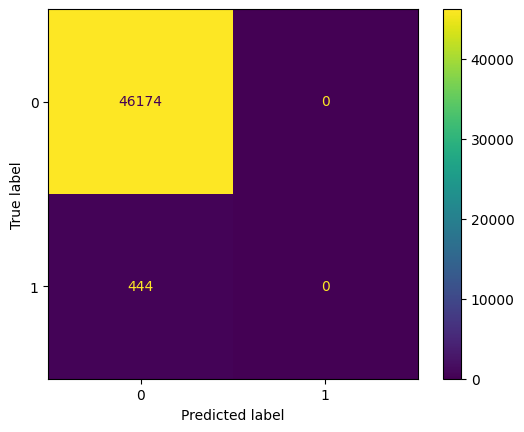

In [53]:
# plotting confusion matrix
plot_confusion_matrix(y_actuals=y_train, y_preds=train_baseline_preds)

Resulting to high accuracy scores, but scoring 0 on precision, recall, and F1 scores. This is expected since the majority class is 0 and the baseline model is predicting only 0.

### 8. Train Machine Learning Model

In [54]:
import xgboost as xgb

In [55]:
# choosing initial scale to account for imbalance (# of negative classes / # of positive classes)
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

print('Scale class weight: ', scale_weight)

# initialize model
model = xgb.XGBClassifier(scale_pos_weight = scale_weight, eval_metric='auc', booster='gbtree', random_state=10)

Scale class weight:  103.99549549549549


### 9. Assess Model Performance

In [56]:
# KFold cross validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

# Doing 10 splits
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=10)

dict_eval_metrics = {'accuracy': accuracy_score,
             'precision': precision_score,
             'recall': recall_score,
             'f1': f1_score,
            }

def evaluate_cv_predictions(X, y, model):
  """
  function to display mean, std, and median cross validation scores
  """
  fig, ax = plt.subplots(1,4, figsize = (20,5))
  plt.tight_layout(pad=2)
  ax = ax.flatten()

  score_list_mean = []
  score_list_std = []
  score_list_median = []

  for idx,key in enumerate(dict_eval_metrics.keys()):
    scores = cross_val_score(model, X, y, scoring=key, cv=cv, n_jobs=-1)

    sns.boxplot(scores, ax=ax[idx])
    ax[idx].set_title(key)

    score_list_mean.append(np.mean(scores))
    score_list_std.append(np.std(scores))
    score_list_median.append(np.median(scores))

  display(pd.DataFrame({'Mean':score_list_mean, 'STD':score_list_std, 'Median':score_list_median}, index=dict_eval_metrics.keys()))
  plt.show()

,Mean,STD,Median
accuracy,0.994401,0.001304,0.994423
precision,0.680275,0.080056,0.666667
recall,0.813340,0.090322,0.818182
f1,0.734544,0.056259,0.747549


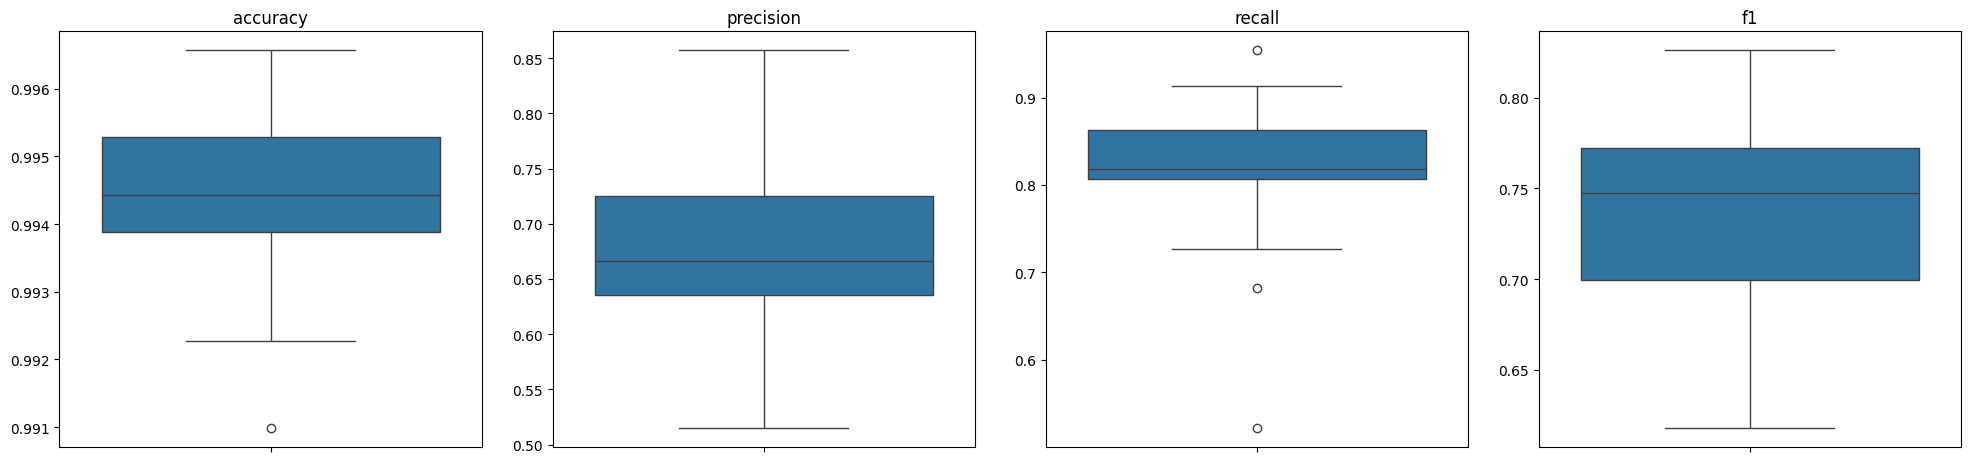

In [57]:
# scores for undersampling training
evaluate_cv_predictions(X_train, y_train, model)

Recall is the more important metric for this case. Business priority is to determine fraud, but also has leeway to raise false alarms (false positives).

In [58]:
# generate cross validation predictions for training data
y_cv_probs = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:,1]
y_cv_preds = (y_cv_probs >= 0.5).astype(int)

In [59]:
# checking pred values
print(y_cv_preds)

[0 0 0 ... 0 0 0]


In [60]:
# checking probability values
print(y_cv_probs)

[4.3027344e-06 2.4196811e-06 1.0729080e-05 ... 2.0454499e-06 2.2781412e-06
 3.9372679e-07]


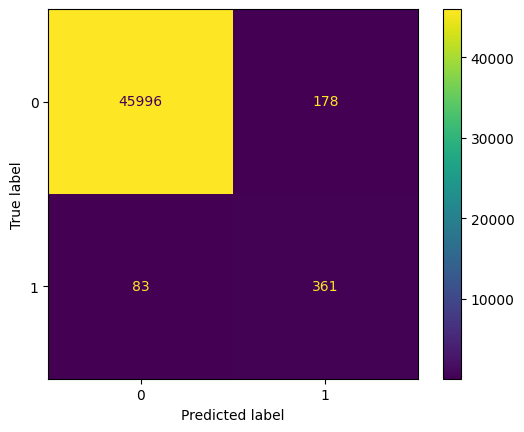

In [61]:
plot_confusion_matrix(y_actuals=y_train, y_preds=y_cv_preds)

The initial model has high recall, given that the initial scale was high. This is also a good sign given that the initial model is able to predict positive classes that are only less than 0.1% of the whole distribution.

In [62]:
from grp_krml_group3.models.performance import plot_auroc_curve

AUROC score: 0.9960


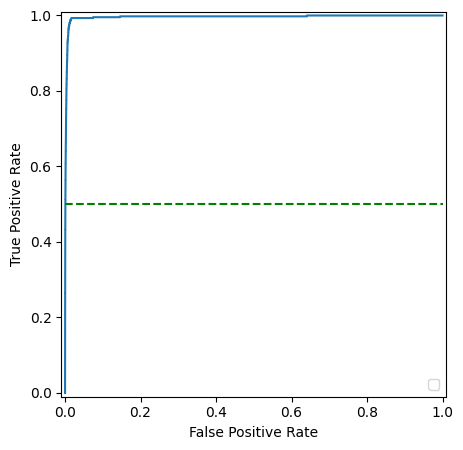

In [63]:
plot_auroc_curve(y_actuals=y_train, y_probs=y_cv_probs)

### 10. Hyperparameter Tuning

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint

In [65]:
param_grid = {
            'scale_pos_weight':loguniform(1e1, 1e3), # default=1
            'max_depth':randint(5,10), # default=6
            'learning_rate':uniform(0,0.2), # default=0.3
            'subsample':loguniform(0.7,0.95), # default=1
            'reg_lambda':loguniform(1e-2,100), # default=1
            'reg_alpha':loguniform(1e-2,100), # default=0
            'min_child_weight':randint(1,10) # default=1
              }

In [66]:
# grid search model
xgb_opt = xgb.XGBClassifier(eval_metric='auc', booster='gbtree', random_state=10)
scoring_metric = 'roc_auc'

random_search = RandomizedSearchCV(xgb_opt, param_grid, verbose=0, n_jobs=-1, scoring=scoring_metric, cv=cv, random_state=10)

random_search.fit(X_train, y_train)
print('Optimized Params: ', random_search.best_params_)
print('Optimized Params Score: ', random_search.best_score_)

Optimized Params:  {'learning_rate': np.float64(0.10850887360225225), 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': np.float64(0.05376823062708377), 'reg_lambda': np.float64(20.152502838528783), 'scale_pos_weight': np.float64(16.24814054324821), 'subsample': np.float64(0.7633216094195376)}
Optimized Params Score:  0.9982605531659257


[Optimised Train Results]


,Mean,STD,Median
accuracy,0.993372,0.001458,0.993136
precision,0.607928,0.067060,0.588964
recall,0.910079,0.066886,0.931818
f1,0.725134,0.047452,0.724138


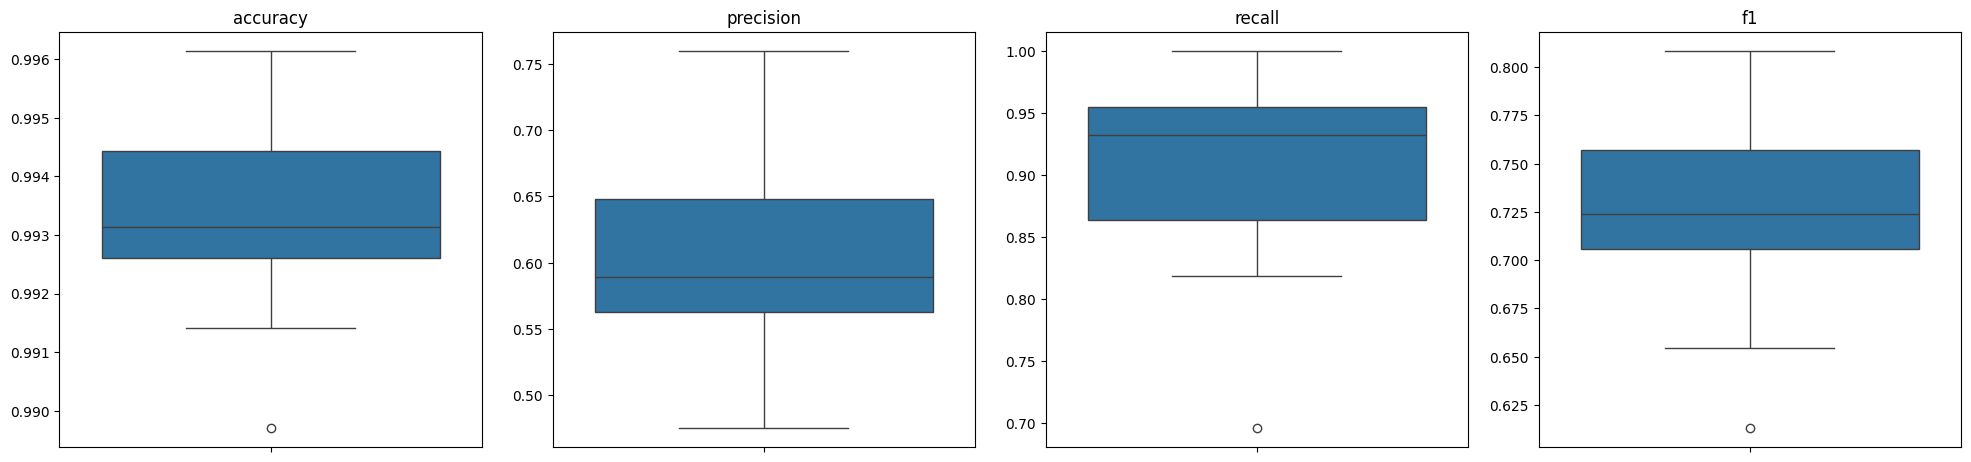

In [67]:
# generate cross validation predictions for undersampling training data
y_cv_opt_probs = cross_val_predict(random_search.best_estimator_, X_train, y_train, cv=cv, method='predict_proba')[:,1]
y_cv_opt_preds = (y_cv_opt_probs >= 0.5).astype(int)

print('[Optimised Train Results]')
evaluate_cv_predictions(X_train, y_train, random_search.best_estimator_)

Confusion Matrix - Optimised Params


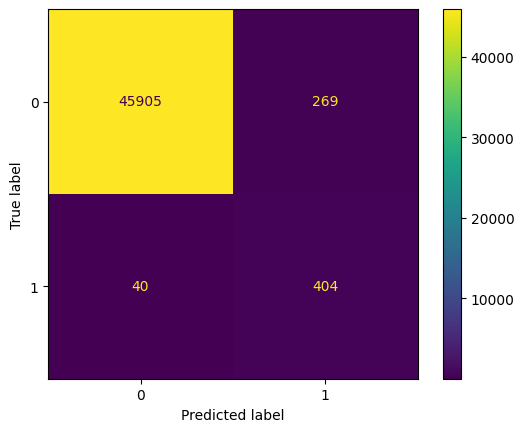

In [68]:
print('Confusion Matrix - Optimised Params')
plot_confusion_matrix(y_actuals=y_train, y_preds=y_cv_opt_preds)

AUROC Curves - Optimised Params
AUROC score: 0.9982


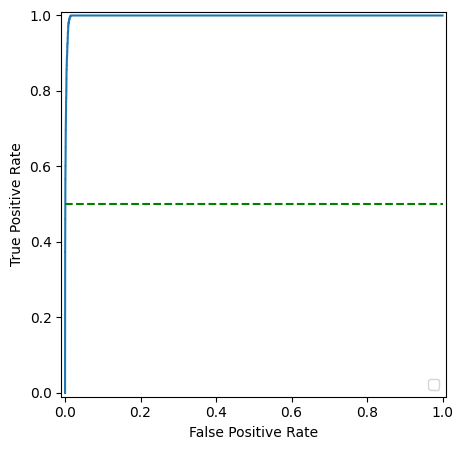

In [69]:
print('AUROC Curves - Optimised Params')
plot_auroc_curve(y_actuals=y_train, y_probs=y_cv_opt_probs)

In conclusion, the test evaluations, after hyperparameter tuning as well as classification threshold tuning, show that the model is able to properly distinguish between the two classes, for unseen data. Given that it has satisfied the business requirements, strong considerations to deploy is recommended.

### 11. Predict Test Set Probabilities

In [70]:
# ensuring no test records were lost
print(len(df_test))
print(len(df[df['set_type'] == 'test']))

4970
4970


In [71]:
# predicting probabilities
X_test_unk = df[df['set_type'] == 'test'].drop([target, 'set_type'], axis=1)
y_test_opt_unk_probs = random_search.predict_proba(X_test_unk)[:,1]

# writing to csv
pd.DataFrame(data={'player_id':df_test['player_id'].values, 'drafted':y_test_opt_unk_probs}).to_csv('../data/processed/kaggle_predictions/xgboost-week5_v3.csv', index=False)

### 12. Feature Importance

In [72]:
import shap

In [73]:
explainer = shap.TreeExplainer(random_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

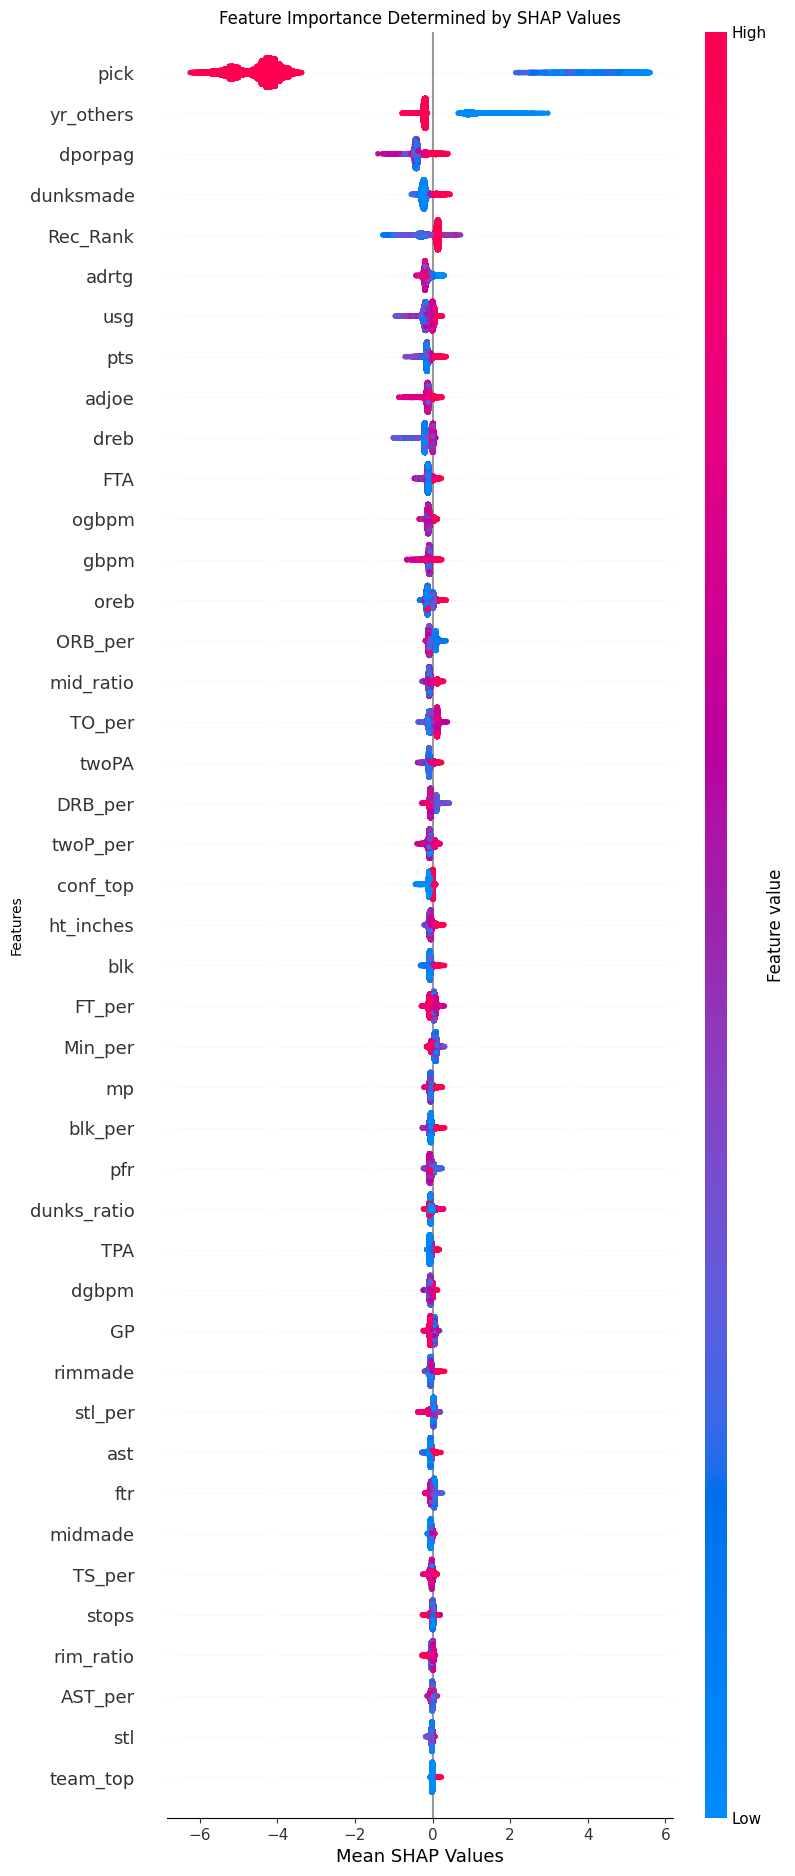

In [74]:
fig = shap.summary_plot(shap_values, X_train, show=False, class_names=['High Adapativity','Moderate Adaptivity', 'Low Adaptivity'], max_display = len(X_train.columns))
plt.title('Feature Importance Determined by SHAP Values')
plt.xlabel('Mean SHAP Values')
plt.ylabel('Features')
plt.show()

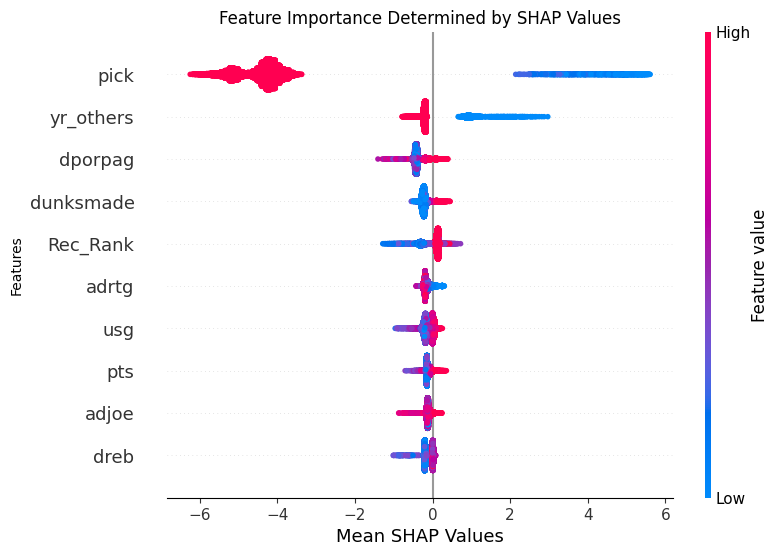

In [75]:
fig = shap.summary_plot(shap_values, X_train, show=False, class_names=['High Adapativity','Moderate Adaptivity', 'Low Adaptivity'], max_display = 10)
plt.title('Feature Importance Determined by SHAP Values')
plt.xlabel('Mean SHAP Values')
plt.ylabel('Features')
plt.show()

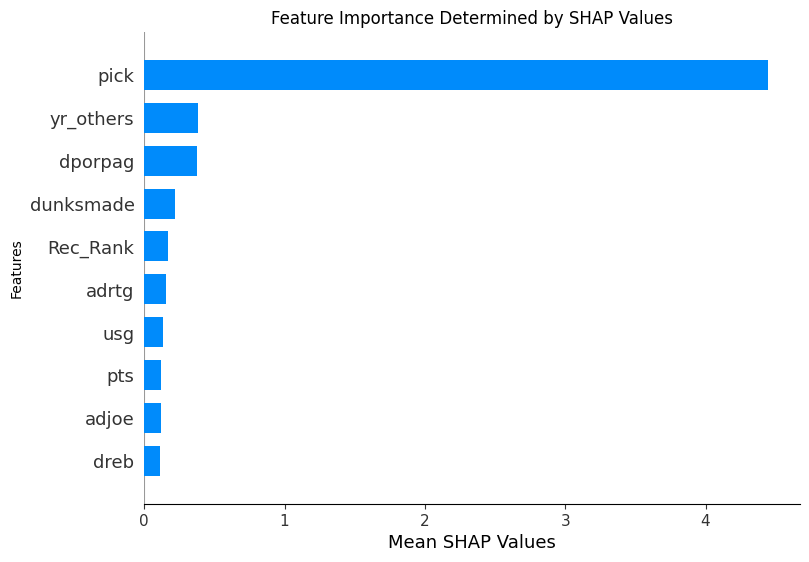

In [76]:
fig = shap.summary_plot(shap_values, X_train, show=False, class_names=['High Adapativity','Moderate Adaptivity', 'Low Adaptivity'], max_display = 10, plot_type='bar')
plt.title('Feature Importance Determined by SHAP Values')
plt.xlabel('Mean SHAP Values')
plt.ylabel('Features')
plt.show()